In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib
import os
import xgboost as xgb
import shap

from scripts.dataLoader import dataLoaderParallel

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# feature parameters
SIGNAL_FEATURE = ['mbp', 'sbp', 'dbp', 'hr', 'rr', 'spo2', 'etco2', 'mac', 'pp_ct']
STATIC_FEATURE = ["age", "bmi", "asa", "preop_cr", "preop_htn", "sex"]
HALF_TIME_FILTERING = [10, 60, 5*60] # secondes

# model parameters
N_ESTIMATORS = np.logspace(1.5, 2.7, 3, dtype=int)
MAX_DEPTH = [3,5,7]
LEARNING_RATE = np.logspace(-2, -1, 2)
LAMBDA = 7
MIN_CHILD_WEIGHT = [3, 6]
ROUND_NUMBER = 75
OBJECTIVE = ['binary:logistic']
METRIC = ['auc']

In [3]:
# test if raw file exists
if not os.path.exists('data/data_async.csv'):
    print('data_async.csv does not exist, please run dataset_download.py first')
    exit()
cols = list(pd.read_csv("data/data_async.csv", nrows=1))

rawData = pd.read_csv(f'data/data_async.csv', usecols =[i for i in cols if i != "opname"])


In [4]:

    
if not os.path.exists('data/data_xbg.csv'):
    dataframe = dataLoaderParallel(
        half_times= HALF_TIME_FILTERING,
        signal_name=SIGNAL_FEATURE,
        static_data=STATIC_FEATURE,
        max_number_of_case=5000,
        rawData= rawData,
        leading_time= 0,#3*60,
        prediction_windows=60*10
    )
    dataframe.to_csv('data/data_xbg.csv', index=False)
else:
    dataframe = pd.read_csv('data/data_xbg.csv')

Processing caseid: 100%|██████████| 1599/1599 [32:36<00:00,  1.22s/it] 


Number of raw segment: 638140
Number of selected segment: 95401


In [5]:
# for each subgoup of data, create a regressor and evaluate it
from sklearn.metrics import auc, roc_curve
from scripts.optuna_tuning import objective
import optuna

n_bootstraps = 200
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)


tpr_list, auc_list, thr_list  = [], [], []
tpr_train_list, auc_train_list  = [], []
sensitivity_list, specificity_list, ppv_list, npv_list = [], [], [], []
fpr = np.linspace(0, 1, 100)

FEATURE_NAME = [f'{signal}_ema_{half_time}' for signal in SIGNAL_FEATURE for half_time in HALF_TIME_FILTERING] + [f'{signal}_var_{half_time}' for signal in SIGNAL_FEATURE for half_time in HALF_TIME_FILTERING] + STATIC_FEATURE

# get caseid of cases where propofol >0


for cv, test in dataframe.groupby('cv_group'):

    # create a regressor

    train = dataframe[dataframe['cv_group'] != cv]
    train = train.dropna(subset=FEATURE_NAME)
    test = test.dropna(subset=FEATURE_NAME)
    print(f'cv {cv} : {len(train)} train samples and {len(test)} test samples, positive rate = {test["label"].mean():.2f}')

    # try to open the model
    try:
        model = xgb.XGBClassifier()
        model.load_model(f'data/models/xgb_{cv}.json')
    except:

        # creat an optuna study
        study = optuna.create_study(direction="maximize")
        study.optimize(lambda trial: objective(trial, train, FEATURE_NAME), n_trials=100)
        # get the best hyperparameters
        best_params = study.best_params
        # ret
        #refit the model with best parameters
        model = xgb.XGBClassifier(**best_params)
        model.fit(train[FEATURE_NAME], train.label, verbose=1)
        #save the model
        model.save_model(f'data/models/xgb_{cv}.json')

    # get training auc
    y_pred = model.predict_proba(train[FEATURE_NAME])[:, 1]
    y_train = train['label'].values
    fpr_, tpr_, _ = roc_curve(y_train, y_pred)
    auc_ = auc(fpr_, tpr_)

    tpr_train_list.append(np.interp(np.linspace(0, 1, 100), fpr_, tpr_))
    auc_train_list.append(auc_)

    y_pred = model.predict_proba(test[FEATURE_NAME])[:, 1]
    y_test = test['label'].values

    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_test[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        fpr_, tpr_, thr_ = roc_curve(y_test[indices], y_pred[indices])
        auc_ = auc(fpr_, tpr_)
        gmean = np.sqrt(tpr_ * (1-fpr_))
        id_thresh_opt = np.argmax(gmean)
        sensitivity_list.append(tpr_[id_thresh_opt]*100)
        specificity_list.append((1-fpr_[id_thresh_opt])*100)
        prevalence = np.mean(y_test[indices])
        ppv_list.append(100 * tpr_[id_thresh_opt]*prevalence / (tpr_[id_thresh_opt]*prevalence + fpr_[id_thresh_opt]*(1-prevalence)))
        npv_list.append(100 * (1-fpr_[id_thresh_opt])*(1-prevalence) / ((1-tpr_[id_thresh_opt])*prevalence + (1-fpr_[id_thresh_opt])*(1-prevalence)))


        tpr_list.append(np.interp(np.linspace(0, 1, 100), fpr_, tpr_))
        thr_list.append(np.interp(np.linspace(0, 1, 100), fpr_, thr_))
        auc_list.append(auc_)  


# compute mean ROC curve
tpr_mean = np.mean(tpr_list, axis=0)
tpr_std = np.std(tpr_list, axis=0)
thr_mean = np.mean(thr_list, axis=0)
sensi_mean = np.mean(sensitivity_list)
speci_mean = np.mean(specificity_list)
ppv_mean = np.mean(ppv_list)
npv_mean = np.mean(npv_list)
sensi_std = np.std(sensitivity_list)
speci_std = np.std(specificity_list)
ppv_std = np.std(ppv_list)
npv_std = np.std(npv_list)

# save the ROC curve
df = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr_mean,
    'tpr_std':tpr_std,
    'threshold': thr_mean,
    'auc': np.round(np.mean(auc_list),2),
    'auc_std': np.round(pd.Series(auc_list).std(),2),
        'sensitivity': sensi_mean,
    'sensitivity_std': sensi_std,
    'specificity': speci_mean,
    'specificity_std': speci_std,
    'ppv': ppv_mean,
    'ppv_std': ppv_std,
    'npv': npv_mean,
    'npv_std': npv_std,
})
df.to_csv('data/xgboost_roc.csv', index=False)




[I 2024-02-29 13:00:52,329] A new study created in memory with name: no-name-002a7284-74e8-4b41-9cf8-a4b3c02f1305


cv 0 : 75362 train samples and 20039 test samples, positive rate = 0.08


[I 2024-02-29 13:00:55,955] Trial 0 finished with value: 0.5465329568790757 and parameters: {'max_depth': 7, 'learning_rate': 0.05189236520855437, 'n_estimators': 75, 'min_child_weight': 1, 'gamma': 0.0038306909680418215, 'subsample': 0.018848816034983215, 'colsample_bytree': 0.9848196081640572, 'reg_alpha': 2.5896582044267347e-05, 'reg_lambda': 1.484748856269321e-07}. Best is trial 0 with value: 0.5465329568790757.
[I 2024-02-29 13:00:59,763] Trial 1 finished with value: 0.5047605316652292 and parameters: {'max_depth': 3, 'learning_rate': 0.024503978735762964, 'n_estimators': 215, 'min_child_weight': 3, 'gamma': 3.911954444587698e-05, 'subsample': 0.3344946394690458, 'colsample_bytree': 0.1778015248704565, 'reg_alpha': 0.0471560980624449, 'reg_lambda': 2.655907816904776e-08}. Best is trial 0 with value: 0.5465329568790757.
[I 2024-02-29 13:01:11,906] Trial 2 finished with value: 0.5332519612868487 and parameters: {'max_depth': 7, 'learning_rate': 0.09587632633206558, 'n_estimators': 3

cv 1 : 76879 train samples and 18522 test samples, positive rate = 0.07


[I 2024-02-29 13:13:14,638] Trial 0 finished with value: 0.5499536509145008 and parameters: {'max_depth': 6, 'learning_rate': 0.05869261702484839, 'n_estimators': 490, 'min_child_weight': 9, 'gamma': 1.2849145450178221e-06, 'subsample': 0.05830082037218165, 'colsample_bytree': 0.3244495012245233, 'reg_alpha': 8.678794366030303e-08, 'reg_lambda': 6.95123930247976e-07}. Best is trial 0 with value: 0.5499536509145008.
[I 2024-02-29 13:13:23,316] Trial 1 finished with value: 0.5039676978900216 and parameters: {'max_depth': 4, 'learning_rate': 0.028635353465608786, 'n_estimators': 475, 'min_child_weight': 1, 'gamma': 4.5101981824981246e-07, 'subsample': 0.18107597632515013, 'colsample_bytree': 0.04050526695772971, 'reg_alpha': 0.15061587266375298, 'reg_lambda': 0.14671024846154013}. Best is trial 0 with value: 0.5499536509145008.
[I 2024-02-29 13:13:30,021] Trial 2 finished with value: 0.5167995354118875 and parameters: {'max_depth': 7, 'learning_rate': 0.0567561745160533, 'n_estimators': 4

cv 2 : 75829 train samples and 19572 test samples, positive rate = 0.06


[I 2024-02-29 13:21:34,995] Trial 0 finished with value: 0.5231419571916844 and parameters: {'max_depth': 8, 'learning_rate': 0.12338147409838979, 'n_estimators': 350, 'min_child_weight': 3, 'gamma': 0.0004260506925224545, 'subsample': 0.27321624597903643, 'colsample_bytree': 0.05174929246904232, 'reg_alpha': 0.3757859567760235, 'reg_lambda': 0.004069531169042849}. Best is trial 0 with value: 0.5231419571916844.
[I 2024-02-29 13:21:44,119] Trial 1 finished with value: 0.5001017608627715 and parameters: {'max_depth': 5, 'learning_rate': 0.01123680203634024, 'n_estimators': 453, 'min_child_weight': 9, 'gamma': 0.007715246015397712, 'subsample': 0.1390199443918063, 'colsample_bytree': 0.07447338639519302, 'reg_alpha': 7.017378929795664e-07, 'reg_lambda': 0.0332674691895734}. Best is trial 0 with value: 0.5231419571916844.
[I 2024-02-29 13:21:46,381] Trial 2 finished with value: 0.5003479319958067 and parameters: {'max_depth': 2, 'learning_rate': 0.08788833035059687, 'n_estimators': 148, '

KeyboardInterrupt: 

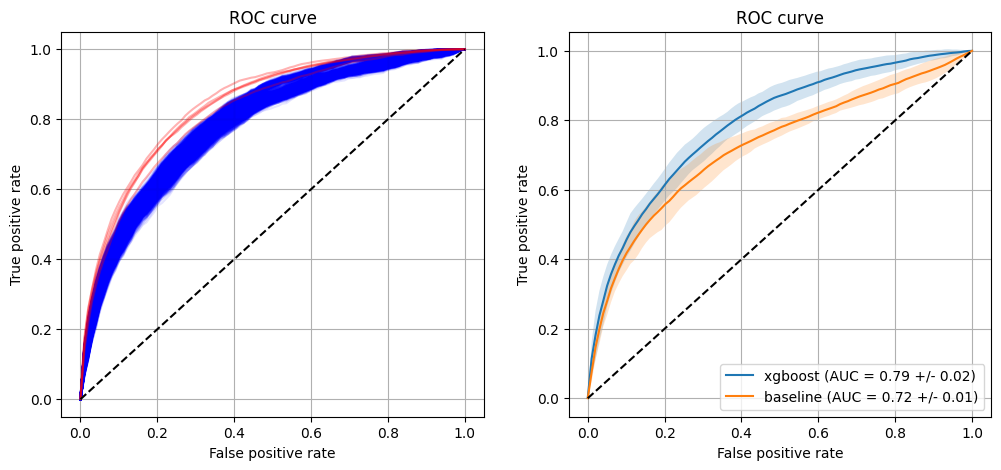

Z-score = 3.70
p-value = 0.0001


In [ ]:

# plot the ROC curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(len(tpr_list)):
    plt.plot(fpr, tpr_list[i], 'b', alpha=0.1)
for i in range(len(tpr_train_list)):
    plt.plot(fpr, tpr_train_list[i], 'r', alpha=0.3)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.grid()

plt.subplot(1, 2, 2)
plt.fill_between(fpr, tpr_mean - 2*tpr_std, tpr_mean + 2*tpr_std, alpha=0.2)
plt.plot(fpr, tpr_mean, label=f'xgboost (AUC = {np.mean(auc_list):.2f} +/- {pd.Series(auc_list).std():.2f})')

#add baseline to the plot
df_baseline = pd.read_csv('data/baseline_roc.csv')
plt.fill_between(df_baseline.fpr, df_baseline.tpr - 2*df_baseline.tpr_std, df_baseline.tpr + 2*df_baseline.tpr_std, alpha=0.2)
plt.plot(df_baseline.fpr.values, df_baseline.tpr.values, label=f'baseline (AUC = {df_baseline.auc[0]:.2f} +/- {df_baseline.auc_std[0]:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.grid()
plt.show()

Z_score = (np.mean(auc_list) - df_baseline.auc[0])/np.sqrt(df_baseline.auc_std[0]**2 + pd.Series(auc_list).std()**2)
print(f'Z-score = {Z_score:.2f}')
import scipy.stats
p_value = scipy.stats.norm.sf(abs(Z_score)) #one-sided
# p_value = 1 - 0.5*(1 + np.math.erf(Z_score/np.sqrt(2)))
print(f'p-value = {p_value:.4f}')


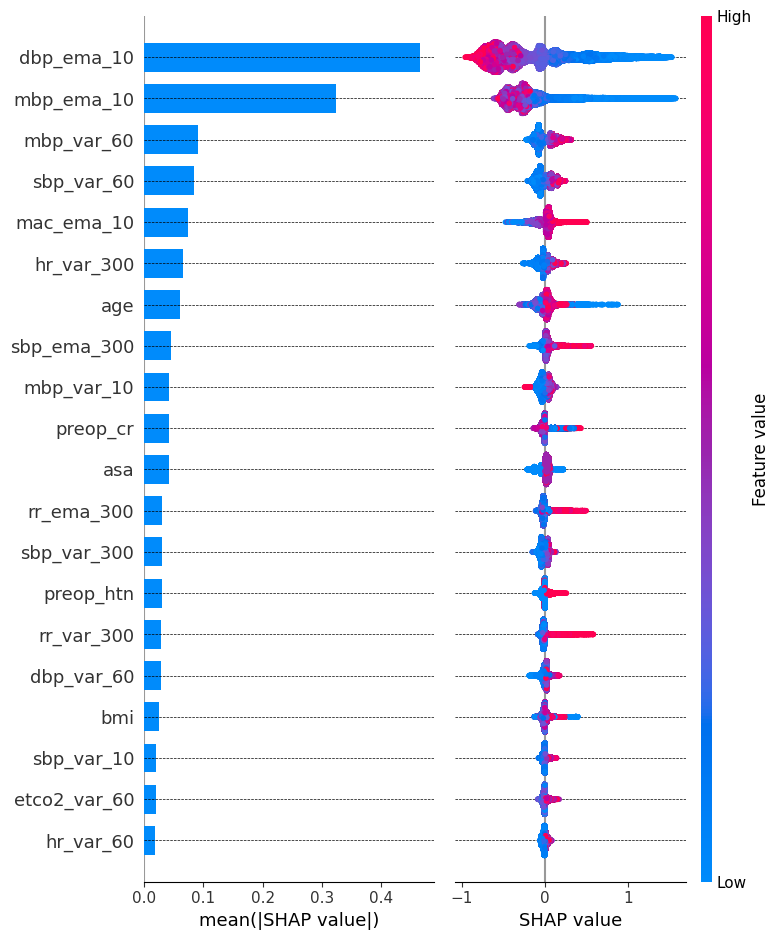

In [ ]:
# use SHAP to explain the model
shap.initjs()
nb_max_feature = 20
shap_values_tot = []
test_data = pd.DataFrame()
for cv, test in dataframe.groupby('cv_group'):
    model = xgb.Booster()
    model.load_model(f'data/models/xgb_{cv}.json')
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(test[FEATURE_NAME])
    for shape in shap_values:
        shap_values_tot.append(shape)
    test_data= pd.concat([test_data, test[FEATURE_NAME]])

# plot the SHAP value
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(nb_max_feature):
    plt.axhline(y=i, color='black', linestyle='--', linewidth=0.5)
shap.summary_plot(np.array(shap_values_tot), test_data, feature_names=FEATURE_NAME, show=False, plot_type="bar", max_display=nb_max_feature)
plt.xlabel('mean(|SHAP value|)')
plt.subplot(1, 2, 2)
shap.summary_plot(np.array(shap_values_tot), test_data, feature_names=FEATURE_NAME, show=False, max_display=nb_max_feature)
#remove the y thick label
plt.gca().set_yticklabels([])
plt.xlabel('SHAP value')
plt.tight_layout()
#add horizontal line for each feture
for i in range(nb_max_feature):
    plt.axhline(y=i, color='black', linestyle='--', linewidth=0.5)
plt.savefig('./report/figures/shap_xgboost.pdf', bbox_inches='tight', dpi=600)
plt.show()

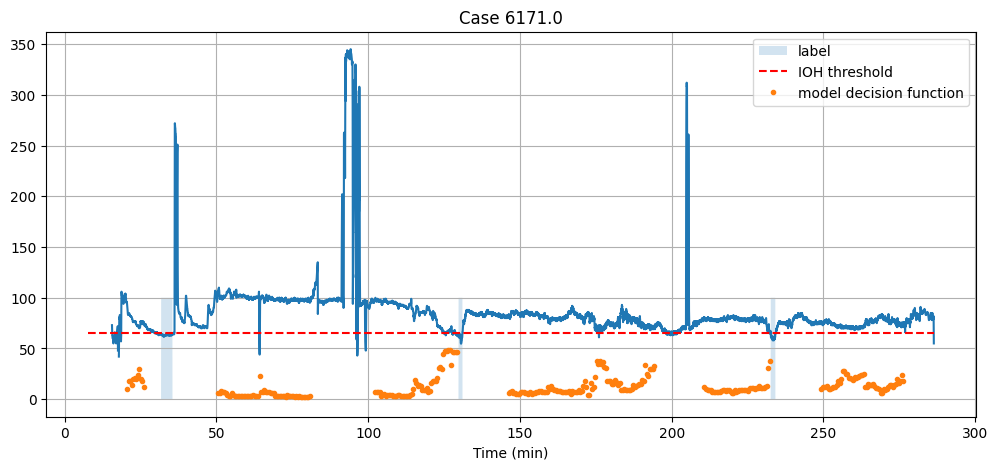

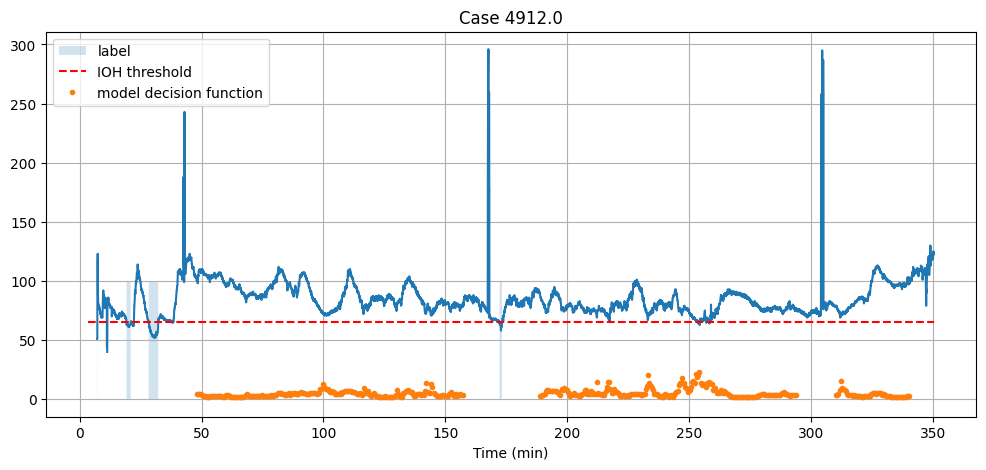

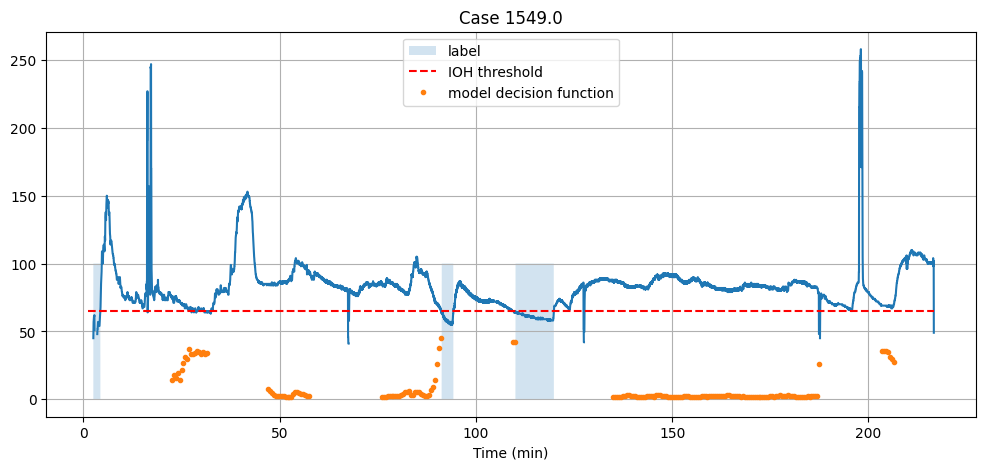

In [ ]:
from scripts.dataLoader import label_caseid

np.random.seed(1)
cases = np.random.choice(dataframe['caseid'].unique(), 3, replace=False)

for case in cases:
    raw_case = rawData[rawData.caseid == case].copy()
    raw_case.rename(columns={'Solar8000/ART_MBP': 'mbp'}, inplace=True)
    raw_case.mbp.mask(raw_case.mbp < 40, inplace=True)
    # removing the nan values at the beginning and the ending
    case_valid_mask = ~raw_case.mbp.isna()
    raw_case = raw_case[(np.cumsum(case_valid_mask) > 0) & (np.cumsum(case_valid_mask[::-1])[::-1] > 0)]


    raw_case= label_caseid(raw_case, 2)

    segment_data = dataframe[dataframe['caseid'] == case]
    cv_group = segment_data['cv_group'].values[0]


    segment_data = segment_data.dropna(subset=FEATURE_NAME)
    x_test = segment_data[FEATURE_NAME]
    y_test = segment_data['label'].values
    
    # load model
    model = xgb.XGBClassifier()
    model.load_model(f'data/models/xgb_{cv_group}.json')
    y_pred = model.predict_proba(x_test)[:, 1]

    plt.figure(figsize=(12, 5))
    plt.fill_between(raw_case['Time']*2/60, np.zeros(len(raw_case['Time'])), raw_case.label*100, label='label', alpha=0.2)
    plt.plot(raw_case['Time']*2/60, raw_case['mbp'])
    plt.hlines(65, raw_case['Time'].values[0]/60, raw_case['Time'].values[-1]*2/60, color='r', linestyle='--', label='IOH threshold')
    plt.plot(segment_data['time']/60,y_pred*100, '.', label='model decision function')
    # plt.plot(segment_data['time']/60, segment_data[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'], '*', label='label')
    plt.xlabel('Time (min)')
    # plt.xlim([35, 42])
    # plt.xlim([235, 245])
    # plt.ylim([42, 80])
    plt.legend()
    plt.title(f'Case {case}')
    plt.grid()
    plt.show()